# LSTM Model Evaluation

This notebook evaluates the pre-trained LSTM model for agricultural water need prediction.

In [2]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set paths relative to the models directory
DATA_PATH = "../data.csv"
MODEL_PATH = "lstm_model.keras"
SCALER_PATH = "lstm_scaler.joblib"

## 1. Data Preparation
Mirroring the logic found in `main.py`.

In [3]:
def weather_to_agricultural_features(df):
    df_agri = df.copy()
    # Standardize column names based on data.csv format
    df_agri['temperature'] = df_agri['T (degC)'] if 'T (degC)' in df_agri.columns else df_agri.get('T', 20)
    df_agri['humidity'] = df_agri['rh (%)'] if 'rh (%)' in df_agri.columns else df_agri.get('rh', 50)
    df_agri['pressure'] = df_agri['p (mbar)'] if 'p (mbar)' in df_agri.columns else df_agri.get('p', 1013)
    df_agri['wind_speed'] = df_agri['wv (m/s)'] if 'wv (m/s)' in df_agri.columns else df_agri.get('wv', 2)
    df_agri['dew_point'] = df_agri['Tdew (degC)'] if 'Tdew (degC)' in df_agri.columns else df_agri.get('Tdew', 10)
    
    # Synthetic water need calculation (Target)
    base_water_need = (
        (df_agri['temperature'] - 10) * 0.8 + 
        (100 - df_agri['humidity']) * 0.3 + 
        df_agri['wind_speed'] * 2.0
    )
    df_agri['water_need'] = np.clip(base_water_need, 0, 50)
    return df_agri

# Load and preprocess
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    df_agri = weather_to_agricultural_features(df)
    
    feature_cols = ['temperature', 'humidity', 'pressure', 'wind_speed', 'dew_point']
    X = df_agri[feature_cols].values
    y = df_agri['water_need'].values
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data loaded: {len(df)} rows")
else:
    print(f"ERROR: Data not found at {DATA_PATH}")

Data loaded: 200 rows


## 2. Model Loading & Evaluation
Wait for the model to predict on the test set.

In [4]:
try:
    model = keras.models.load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    
    # Scale test set
    X_test_scaled = scaler.transform(X_test)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Metrics
    mae = np.mean(np.abs(y_test - y_pred.flatten()))
    print(f"Model MAE on Test Set: {mae:.4f} mm")
except Exception as e:
    print(f"ERROR loading model: {e}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step
Model MAE on Test Set: 0.3864 mm


## 3. Retraining for History (Mini Session)
Since the saved `.keras` file doesn't store training history, we run a quick training session to plot the curves.

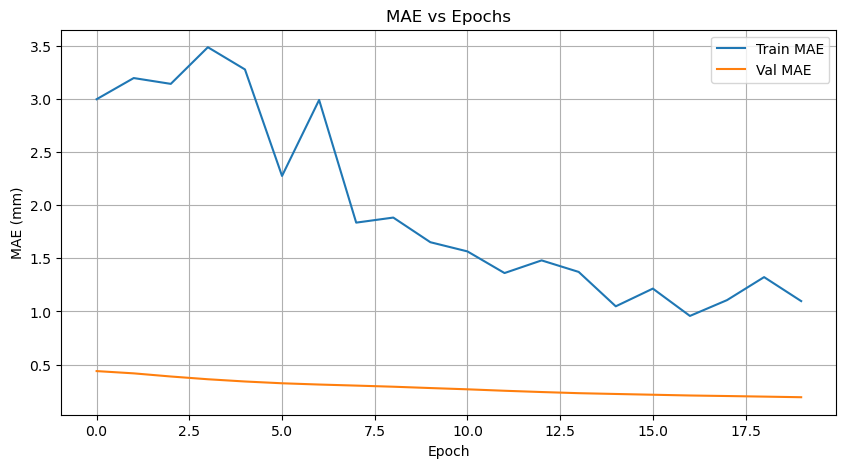

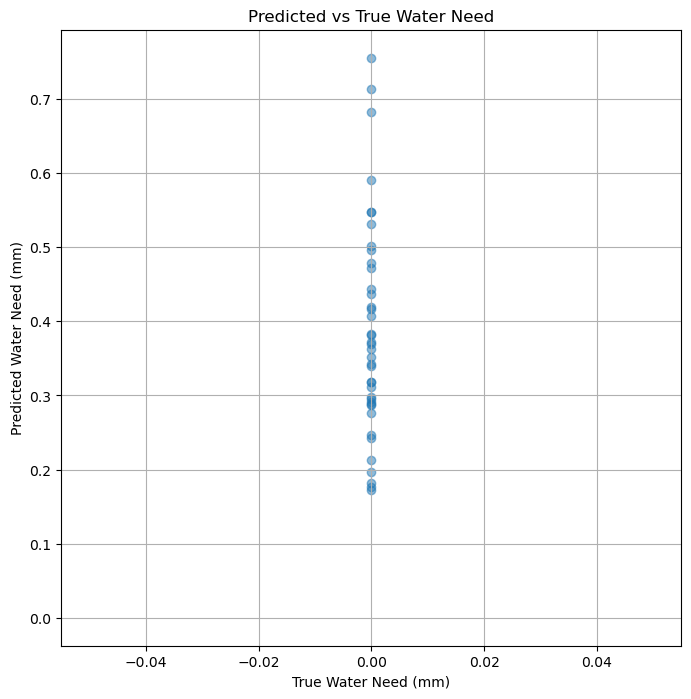

In [5]:
X_train_scaled = scaler.transform(X_train)

# Retrain briefly to get history
history = model.fit(
    X_train_scaled, y_train, 
    validation_split=0.2, 
    epochs=20, 
    batch_size=32, 
    verbose=0
)

# 1. Plot MAE vs Epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE (mm)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot Predicted vs True
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Predicted vs True Water Need')
plt.xlabel('True Water Need (mm)')
plt.ylabel('Predicted Water Need (mm)')
plt.grid(True)
plt.show()